
Dataset and competition for search relevance:

https://www.kaggle.com/c/crowdflower-search-relevance

In [1]:
import pandas as pd

df = pd.read_csv('data/crowdflower-search-relevance.csv', index_col=0)

In [2]:
df.shape

(10158, 5)

In [3]:
df.head()

,query,product_title,product_description,median_relevance,relevance_variance
id,,,,,
1,bridal shower decorations,Accent Pillow with Heart Design - Red/Black,Red satin accent pillow embroidered with a hea...,1,0.000
2,led christmas lights,Set of 10 Battery Operated Multi LED Train Chr...,Set of 10 Battery Operated Train Christmas Lig...,4,0.000
4,projector,ViewSonic Pro8200 DLP Multimedia Projector,NaN,4,0.471
5,wine rack,Concept Housewares WR-44526 Solid-Wood Ceiling...,"Like a silent and sturdy tree, the Southern En...",4,0.000
7,light bulb,Wintergreen Lighting Christmas LED Light Bulb ...,"WTGR1011\nFeatures\nNickel base, 60,000 averag...",2,0.471


In [4]:
df.dropna(inplace=True)

In [5]:
def concat_text(row):
    return row['product_title'] + ' ' + row['product_description']

df['product_title_descr'] = df.apply(concat_text, axis=1)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()

vect.fit(df['product_title_descr'])

product_vectors = vect.transform(df['product_title_descr']).todense()
query_vectors = vect.transform(df['query']).todense()

In [7]:
product_vectors.shape

(7714, 28036)

In [8]:
product_vectors[0].shape

(1, 28036)

In [9]:
query_vectors.shape

(7714, 28036)

In [16]:
from scipy.spatial.distance import cosine, euclidean
                  
df['dist'] = list(map(lambda x: cosine(x[0], x[1]), zip(product_vectors, query_vectors)))

/home/dehling/Documents/machine-learnings/lib/python3.5/site-packages/scipy/spatial/distance.py:649: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [17]:
df[['query', 'product_title', 'median_relevance', 'dist']].sort_values(by=['dist']).head(n=10)

,query,product_title,median_relevance,dist
id,,,,
20622,cast iron skillet,Man Law Cast Iron 12-inch Skillet,4,0.200876
26118,galaxy note 3,"ARCLYTE TECHNOLOGIES, INC. SAMSUNG BATTERY FOR...",2,0.226219
22307,memory foam mattress topper,Select Luxury 3-inch Memory Foam 7-zone Mattre...,4,0.228700
16658,gold toe socks,Gold Toe 3-Pk. Microfiber Socks,4,0.230734
5208,bluetooth speaker,Mini Portable Bluetooth Speaker,4,0.235643
2561,fifa 15,Ea Sports Fifa 15 - Xbox One (36779),4,0.239309
11315,hello kitty,Hello Kitty Hello Kitty HK218 Prescription Eye...,2,0.242603
5124,werewolf costume,Child Werewolf Costume,4,0.242918
3988,minecraft diamond sword,Minecraft Foam Diamond Sword,4,0.253502


In [13]:
df['median_relevance'].corr(df['dist'])

-0.318611530997336

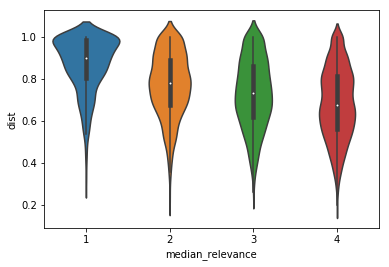

In [14]:
import seaborn as sns
%matplotlib inline

sns.violinplot(x='median_relevance', y='dist', data=df)

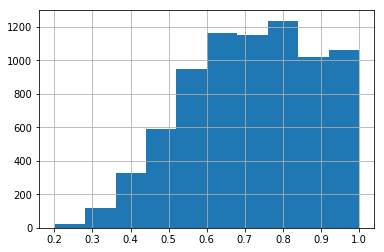

In [15]:
df['dist'].hist()